In [2]:
print('Select Model:')
print ('Available models: \n \t 1. dino (Without Maked modelling) \n \t 2. ibot (Masked Modelling) \n \t 3. attnmask (Masked Modelling)')
select_model = input()
model_list=['../trained_models/dino/output/checkpoint.pth','../trained_models/ibot/output/checkpoint.pth','../trained_models/attnmask/output/checkpoint.pth']
results_list=['../trained_models/dino/output/log.txt','../trained_models/ibot/output/log.txt','../trained_models/attnmask/output/log.txt']
if select_model == 'dino':
    print('Selected dino model without masked modelling')  # Without Masked Modlling
    model_path = model_list[0]
    model_results = results_list[0]
elif select_model == 'ibot':
    print('Selected iBoT with masked modelling')
    model_path = model_list[1]
    model_results = results_list[1]
elif select_model == 'attnmask':
    model_path = model_list[2]
    model_results = results_list[2]
    print('Selected Attn Mask with Masked Modelling')
elif select_model == 'all':
    model_path = model_list
    model_results = results_list
else:
    print('Selected Invalid Model')

Select Model:
Available models: 
 	 1. dino (Without Maked modelling) 
 	 2. ibot (Masked Modelling) 
 	 3. attnmask (Masked Modelling)


In [2]:
from models import VisionTransformer, vit_tiny, vit_small, vit_base, vit_large

import sys
import torch
import requests
import torch.nn as nn
import os
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
from IPython.display import display
from torchvision import transforms as pth_transforms

e:\Conda\envs\dino-torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


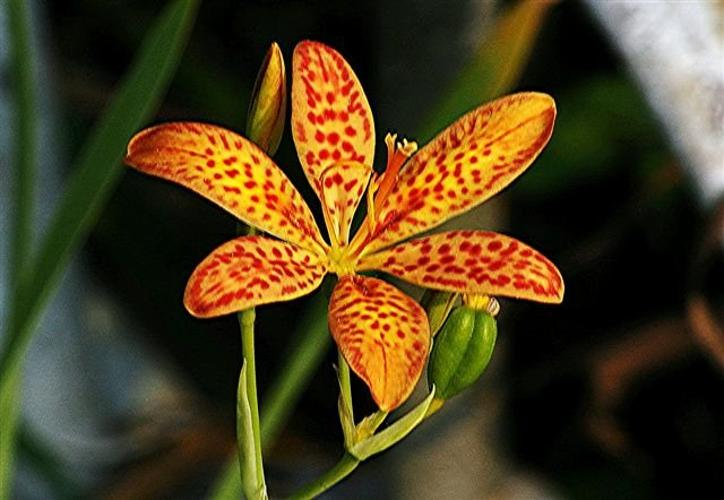

In [3]:
image_path = '../dataset2/dataset/val/102/image_08014.jpg'
img = Image.open(image_path)
img

In [4]:
from analysis.attention_map.visualize_attention import company_colors, apply_mask2

transform = pth_transforms.Compose([
    pth_transforms.Resize([480, 480]),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


In [5]:

def show_attn(img, index=None):
    w_featmap = img.shape[-2] // 16
    h_featmap = img.shape[-1] // 16

    attentions = vit.get_last_selfattention(img.cuda())

    nh = attentions.shape[1] # number of head

    # we keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - 0.6)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()

    # save attentions heatmaps
    prefix = f'id{index}_' if index is not None else ''
    os.makedirs('pics/', exist_ok=True)
    torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join('pics/', "img" + ".png"))
    img = Image.open(os.path.join('pics/', "img" + ".png"))

    attns = Image.new('RGB', (attentions.shape[2] * nh, attentions.shape[1]))
    for j in range(nh):
        fname = os.path.join('pics/', "attn-head" + str(j) + ".png")
        plt.imsave(fname=fname, arr=attentions[j], format='png')
        attns.paste(Image.open(fname), (j * attentions.shape[2], 0))

    return attentions, th_attn, img, attns


In [6]:

def show_attn_color(image, attentions, th_attn, index=None, head=[0,1,2,3,4,5]):
    M = image.max()
    m = image.min()
    span = 64
    image = ((image - m) / (M-m)) * span + (256 - span)
    image = image.mean(axis=2)
    image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    
    for j in head:
        m = attentions[j]
        m *= th_attn[j]
        attentions[j] = m
    mask = np.stack([attentions[j] for j in head])
    
    blur = False
    contour = False
    alpha = 1
    figsize = tuple([i / 100 for i in [480, 480]])
    fig = plt.figure(figsize=figsize, frameon=False, dpi=100)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    if len(mask.shape) == 3:
        N = mask.shape[0]
    else:
        N = 1
        mask = mask[None, :, :]

    # AJ
    for i in range(N):
        mask[i] = mask[i] * ( mask[i] == np.amax(mask, axis=0))
    a = np.cumsum(mask, axis=0)
    for i in range(N):
        mask[i] = mask[i] * (mask[i] == a[i])

    colors = company_colors[:N]

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = 0.1*image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask2(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros(
                (_mask.shape[0] + 2, _mask.shape[1] + 2))#, dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    ax.axis('image')
    #fname = os.path.join(output_dir, 'bnw-{:04d}'.format(imid))
    prefix = f'id{index}_' if index is not None else ''
    fname = os.path.join('pics/', "attn_color.png")
    fig.savefig(fname)
    attn_color = Image.open(fname)
    return attn_color

In [7]:
def load_model(model_path):
    state_dict = torch.load(model_path)
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    vit = vit_base(patch_size=16, return_all_tokens=True).cuda()
    vit.load_state_dict(state_dict, strict=False)
    vit.eval();
    for p in vit.parameters():
        p.requires_grad = False
    return vit

In [8]:
def display_attention_map(img):
    img = transform(img)
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % 16, img.shape[2] - img.shape[2] % 16
    img = img[:, :w, :h].unsqueeze(0)
    attentions, th_attn, pic_i, pic_attn = show_attn(img)
    pic_attn_color = show_attn_color(img[0].permute(1, 2, 0).cpu().numpy(), attentions, th_attn)
    final_pic = Image.new('RGB', (pic_i.size[1] * 2 + pic_attn.size[0], pic_i.size[1]))
    final_pic.paste(pic_i, (0, 0))
    final_pic.paste(pic_attn_color, (pic_i.size[1], 0))
    final_pic.paste(pic_attn, (pic_i.size[1] * 2, 0))
    return final_pic


In [9]:
display_list=[]
if type(model_path) == list:
    for i in range (0,len(model_path)):
        vit = load_model(model_path[i])
        final_pic = display_attention_map(img)
        display_list.append(final_pic)
else:
    vit = load_model(model_path)
    final_pic = display_attention_map(img)



e:\Conda\envs\dino-torch\lib\site-packages\torch\nn\functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
e:\Conda\envs\dino-torch\lib\site-packages\torch\nn\functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


Attention Mask for Dino:


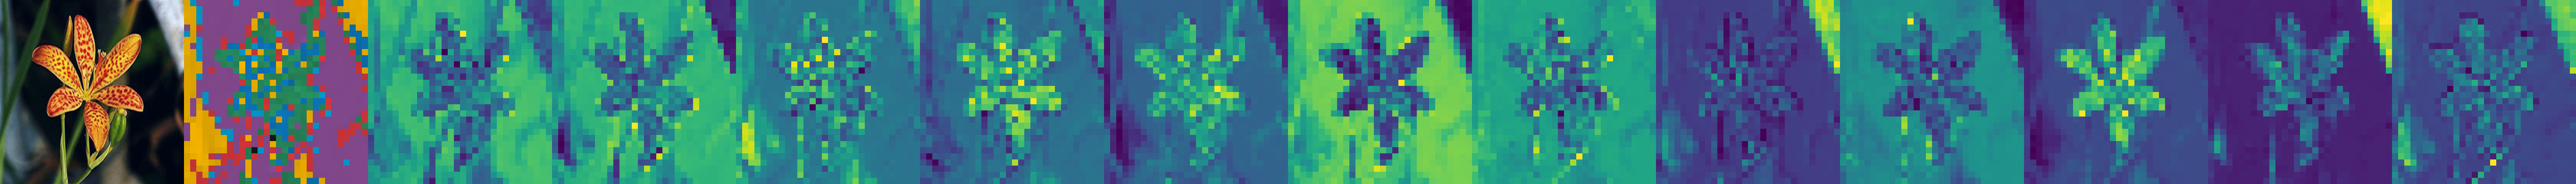

Attention Mask for iBoT:


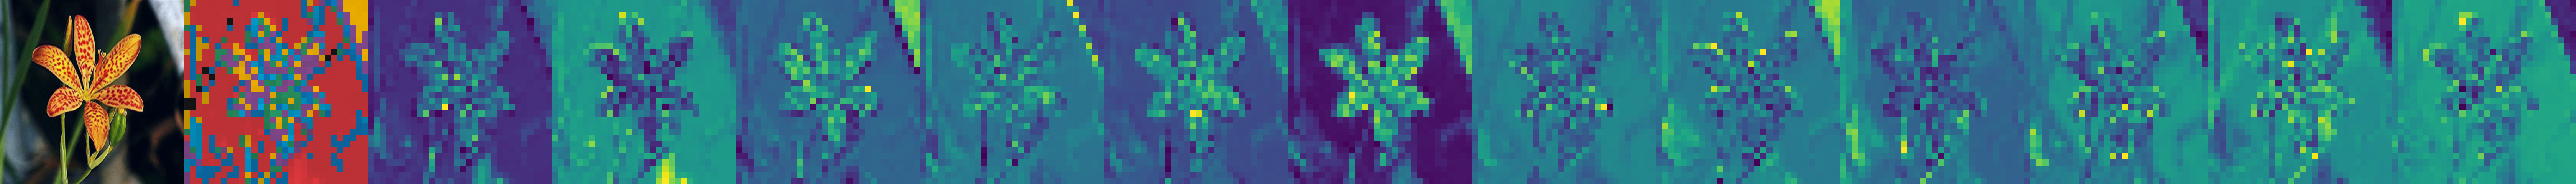

Attention Mask for attnmask:


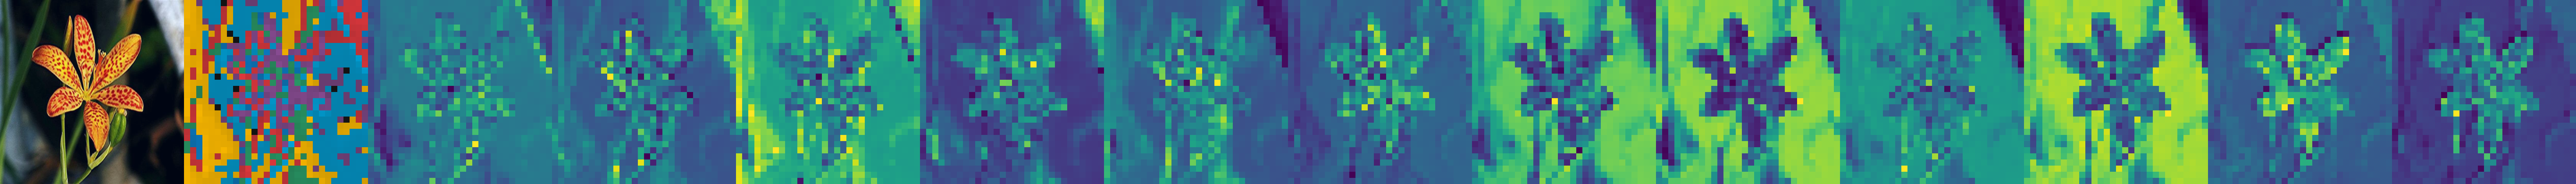

In [10]:
if len(display_list)>0:
    print('Attention Mask for Dino:')
    display(display_list[0])
    print('Attention Mask for iBoT:')
    display(display_list[1])
    print('Attention Mask for attnmask:')
    display(display_list[2])
else:
    print('Attention Map for',select_model,':')
    display(final_pic)


In [80]:
import json
line_array=[]
loss_list=[]
for i in range(0,len(model_results)):
    f=open(model_results[i],"r")
    line_array=f.readlines()
    train_losses = [json.loads(item)['train_loss'] for item in line_array]
    loss_list.append(train_losses)


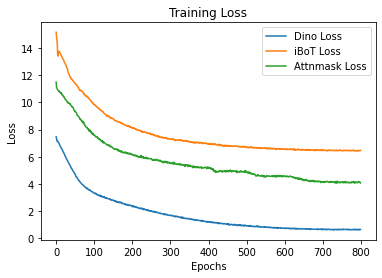

In [93]:
from pickle import load
from matplotlib.pylab import plt
from numpy import arange

epochs =range(0,800)
plt.plot(epochs, loss_list[0], label='Dino Loss')
plt.plot(epochs, loss_list[1], label='iBoT Loss')
plt.plot(epochs, loss_list[2], label='Attnmask Loss')

plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations

 
# Display the plot
plt.legend(loc='best')
plt.show()

In [70]:
f=open(model_results[2],"r")

In [71]:
line_array=[]
line_array=f.readlines()

In [72]:
len(line_array)

800

In [66]:
import json
train_losses = [json.loads(item)['train_loss'] for item in line_array]

In [69]:
line_array

['{"train_loss": 11.496398549021027, "train_cls": 7.722198468667489, "train_patch": 3.774200062692901, "train_lr": 7.725587144622992e-06, "train_wd": 0.04000045410525218, "train_acc": 0.03179012412596264, "train_nmi": 0.18640193055974047, "train_ari": 0.011135126643215129, "train_fscore": 0.03914811035483994, "train_adjacc": -1, "epoch": 0, "k-NN": {"10": {"top1": 13.447432762836186, "top5": 33.12958435207824}, "20": {"top1": 13.569682151589243, "top5": 36.43031784841076}, "100": {"top1": 13.814180929095354, "top5": 38.63080684596577}, "200": {"top1": 13.32518337408313, "top5": 39.608801955990224}}}\n',
 '{"train_loss": 11.111790445115831, "train_cls": 7.520979840078471, "train_patch": 3.5908106285848733, "train_lr": 2.336990111248456e-05, "train_wd": 0.040003212786212064, "train_acc": 0.12530864386554855, "train_nmi": 0.15566317702634827, "train_ari": 0.010682760602080316, "train_fscore": 0.04812546882784904, "train_adjacc": -1, "epoch": 1}\n',
 '{"train_loss": 11.030043719727317, "tr

In [37]:
x=line_array[-10:]

In [40]:
yl=[]
for y in x:
    y=str(x)
    y=y.replace('\n','')
    yl.append(y)

In [41]:
yl

['[\'{"train_loss": 4.112797575232423, "train_cls": 1.7200353072013383, "train_patch": 2.3927622636159263, "train_lr": 1.0555107222884501e-06, "train_wd": 0.3998744770117571, "train_acc": 0.6959876653588848, "train_nmi": 0.6085636819672207, "train_ari": 0.19773087569746725, "train_fscore": 0.22664451888605586, "train_adjacc": -1, "epoch": 790, "k-NN": {"10": {"top1": 73.4718826405868, "top5": 88.63080684596576}, "20": {"top1": 73.71638141809291, "top5": 89.73105134474328}, "100": {"top1": 73.83863080684597, "top5": 90.83129584352078}, "200": {"top1": 74.08312958435208, "top5": 90.83129584352078}}}\\n\', \'{"train_loss": 4.081112626158161, "train_cls": 1.697466650126893, "train_patch": 2.3836459819181464, "train_lr": 1.0444573694903903e-06, "train_wd": 0.3998994713391087, "train_acc": 0.6966049524001133, "train_nmi": 0.6088713392732162, "train_ari": 0.20289779343204126, "train_fscore": 0.23015048823617812, "train_adjacc": -1, "epoch": 791}\\n\', \'{"train_loss": 4.099632575188154, "trai

In [39]:
x=x.replace('\n','')

AttributeError: 'list' object has no attribute 'replace'

In [29]:
x=str(x)


In [31]:
len(x)

3968

In [50]:
import ast
y=ast.literal_eval(y)

ValueError: malformed node or string: ['{"train_loss": 4.112797575232423, "train_cls": 1.7200353072013383, "train_patch": 2.3927622636159263, "train_lr": 1.0555107222884501e-06, "train_wd": 0.3998744770117571, "train_acc": 0.6959876653588848, "train_nmi": 0.6085636819672207, "train_ari": 0.19773087569746725, "train_fscore": 0.22664451888605586, "train_adjacc": -1, "epoch": 790, "k-NN": {"10": {"top1": 73.4718826405868, "top5": 88.63080684596576}, "20": {"top1": 73.71638141809291, "top5": 89.73105134474328}, "100": {"top1": 73.83863080684597, "top5": 90.83129584352078}, "200": {"top1": 74.08312958435208, "top5": 90.83129584352078}}}\n', '{"train_loss": 4.081112626158161, "train_cls": 1.697466650126893, "train_patch": 2.3836459819181464, "train_lr": 1.0444573694903903e-06, "train_wd": 0.3998994713391087, "train_acc": 0.6966049524001133, "train_nmi": 0.6088713392732162, "train_ari": 0.20289779343204126, "train_fscore": 0.23015048823617812, "train_adjacc": -1, "epoch": 791}\n', '{"train_loss": 4.099632575188154, "train_cls": 1.708954796378995, "train_patch": 2.39067777586572, "train_lr": 1.0346308845915873e-06, "train_wd": 0.39992169139406575, "train_acc": 0.6953703849403946, "train_nmi": 0.6099006341979157, "train_ari": 0.20086623992597794, "train_fscore": 0.22995307983999272, "train_adjacc": -1, "epoch": 792}\n', '{"train_loss": 4.09920843736625, "train_cls": 1.7236874294869693, "train_patch": 2.375521006407561, "train_lr": 1.0260314229892378e-06, "train_wd": 0.39994113683396826, "train_acc": 0.687345693140854, "train_nmi": 0.6067338405047369, "train_ari": 0.19603368009544433, "train_fscore": 0.22391055066817123, "train_adjacc": -1, "epoch": 793}\n', '{"train_loss": 4.134002670829679, "train_cls": 1.7208977349010515, "train_patch": 2.4131049315134683, "train_lr": 1.0186591206762455e-06, "train_wd": 0.3999578073589426, "train_acc": 0.6905864300551238, "train_nmi": 0.6080650732454547, "train_ari": 0.2001842051565003, "train_fscore": 0.22913663413550914, "train_adjacc": -1, "epoch": 794}\n', '{"train_loss": 4.094808172296594, "train_cls": 1.7150490946239896, "train_patch": 2.379759082087764, "train_lr": 1.012514094239076e-06, "train_wd": 0.39997170271190924, "train_acc": 0.6921296443468259, "train_nmi": 0.6093336057338375, "train_ari": 0.20196136031557615, "train_fscore": 0.22980664751829633, "train_adjacc": -1, "epoch": 795}\n', '{"train_loss": 4.152815724596565, "train_cls": 1.7118801084565527, "train_patch": 2.440935605837975, "train_lr": 1.0075964408559047e-06, "train_wd": 0.3999828226785843, "train_acc": 0.6908950710002287, "train_nmi": 0.6071478311006694, "train_ari": 0.19657340098443044, "train_fscore": 0.22428038115637455, "train_adjacc": -1, "epoch": 796}\n', '{"train_loss": 4.1149152679207885, "train_cls": 1.72442619153011, "train_patch": 2.3904890660886413, "train_lr": 1.0039062382950851e-06, "train_wd": 0.3999911670874847, "train_acc": 0.6825617397273028, "train_nmi": 0.6100514950232226, "train_ari": 0.19797454746191417, "train_fscore": 0.22608260313236744, "train_adjacc": -1, "epoch": 797}\n', '{"train_loss": 4.1080822208781305, "train_cls": 1.7364855666219452, "train_patch": 2.3715966601430636, "train_lr": 1.0014435449139183e-06, "train_wd": 0.3999967358099286, "train_acc": 0.6822530965746185, "train_nmi": 0.6068210332934405, "train_ari": 0.1987067265731264, "train_fscore": 0.22604509272858397, "train_adjacc": -1, "epoch": 798}\n', '{"train_loss": 4.067556601983529, "train_cls": 1.7076468129216889, "train_patch": 2.359909796420439, "train_lr": 1.000208399657729e-06, "train_wd": 0.39999952876004014, "train_acc": 0.6967592695612966, "train_nmi": 0.6066564031377808, "train_ari": 0.19995494939724434, "train_fscore": 0.22781167823538706, "train_adjacc": -1, "epoch": 799, "k-NN": {"10": {"top1": 73.4718826405868, "top5": 88.63080684596576}, "20": {"top1": 73.71638141809291, "top5": 89.73105134474328}, "100": {"top1": 73.83863080684597, "top5": 90.83129584352078}, "200": {"top1": 74.08312958435208, "top5": 90.83129584352078}}}\n']

In [43]:
y

['{"train_loss": 4.112797575232423, "train_cls": 1.7200353072013383, "train_patch": 2.3927622636159263, "train_lr": 1.0555107222884501e-06, "train_wd": 0.3998744770117571, "train_acc": 0.6959876653588848, "train_nmi": 0.6085636819672207, "train_ari": 0.19773087569746725, "train_fscore": 0.22664451888605586, "train_adjacc": -1, "epoch": 790, "k-NN": {"10": {"top1": 73.4718826405868, "top5": 88.63080684596576}, "20": {"top1": 73.71638141809291, "top5": 89.73105134474328}, "100": {"top1": 73.83863080684597, "top5": 90.83129584352078}, "200": {"top1": 74.08312958435208, "top5": 90.83129584352078}}}\n',
 '{"train_loss": 4.081112626158161, "train_cls": 1.697466650126893, "train_patch": 2.3836459819181464, "train_lr": 1.0444573694903903e-06, "train_wd": 0.3998994713391087, "train_acc": 0.6966049524001133, "train_nmi": 0.6088713392732162, "train_ari": 0.20289779343204126, "train_fscore": 0.23015048823617812, "train_adjacc": -1, "epoch": 791}\n',
 '{"train_loss": 4.099632575188154, "train_cls":

In [49]:
type(y)

list

In [133]:
#x[0]=x[0].replace('{','')
#x[0]=x[0].replace('}','')
x[0]=x[0].replace('\n','')
x[0]=x[0].replace(',','')
#x[0]=x[0].replace(':','')
#x[0]=x[0].replace('"','')

In [134]:
y=x[0].split()

In [135]:
dict(y)

ValueError: dictionary update sequence element #0 has length 14; 2 is required

In [31]:
import os
os.environ['LOCAL_RANK']

KeyError: 'LOCAL_RANK'

Evaluation

    Eval - KNN